In [22]:
import json
import pandas as pd
import numpy as np

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [23]:
df = pd.read_json("https://gist.githubusercontent.com/farhaan-settyl/ecf9c1e7ab7374f18e4400b7a3d2a161/raw/f94652f217eeca83e36dab9d08727caf79ebdecf/dataset.json")
df.head()

,externalStatus,internalStatus
0,PORT OUT,Port Out
1,TERMINAL IN,Inbound Terminal
2,PORT IN,Port In
3,Vessel departure from first POL (Vessel name :...,Departure
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival


In [24]:
df.shape

(1222, 2)

In [25]:
df.isnull().sum()

externalStatus    0
internalStatus    0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   externalStatus  1222 non-null   object
 1   internalStatus  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [27]:
df.duplicated().sum()

1114

In [28]:
df['externalStatus'].value_counts()

externalStatus
Gate out                                                            144
Gate in                                                             143
Discharge                                                           141
Actual time of departure                                             50
DEPARTCU                                                             43
                                                                   ... 
Unloaded from 'YM PLUM 175W' at Port of Discharging YM PLUM 175W      1
Discharge (Vessel name : MSC ORION)                                   1
Load (Vessel name : ELBWATER)                                         1
Discharge (Vessel name : ELBWATER)                                    1
Load on MSC ALEXANDRA / 248W                                          1
Name: count, Length: 108, dtype: int64

In [29]:
df.internalStatus.value_counts()

internalStatus
Loaded on Vessel            331
Departure                   287
Gate Out                    146
Gate In                     143
Arrival                      62
Empty Return                 47
Empty Container Released     47
Unloaded on Vessel           37
Off Rail                     25
On Rail                      25
Outbound Terminal            24
Port Out                     15
Port In                      14
In-transit                   10
Inbound Terminal              9
Name: count, dtype: int64

# Preprocessing Steps

In [30]:
# Cleaning the data
import re

def clean(text):
    # Abbrevation handling
    text = text.replace('POL',"Port of Landing")
    text = text.replace('POD',"Port of Discharge")
    text = text.replace('DEPARTCU',"Departure")
    text = text.replace('CY',"Container Yard")
    text = text.replace('CFS',"Container Freight Station")
    text = text.replace('T/S',"TransShipment")

    #removing unnecessary chars
    text = text.replace('/','')

    # some text that is import to keep so that it wont get removed while cleaning
    not_to_remove = ['TERMINAL','OUT','PORT','IN','TOLL','PLAZA','CROSSED','GATE']

    for i in text.split():
        if i in not_to_remove:
            text = text.replace(i,i.lower())

    # removing quotes text and text in brackets which usually have vessels name
    quote_pattern = r"'([^']*)'"
    text = re.sub(quote_pattern, '', text)

    brackets_pattern = r'\(([^)]*)\)'
    text = re.sub(brackets_pattern, '', text)

    # removing digits and capitalized words which are mostly names of ports and places
    text = re.sub(r'\b[A-Z]+\b', '', text)

    text = re.sub(r'\b\w+\d+\w*\b', '', text)


    return text.strip().lower()


In [31]:
df['cleaned'] = df.externalStatus.apply(clean)

In [32]:
df.head()

,externalStatus,internalStatus,cleaned
0,PORT OUT,Port Out,port out
1,TERMINAL IN,Inbound Terminal,terminal in
2,PORT IN,Port In,port in
3,Vessel departure from first POL (Vessel name :...,Departure,vessel departure from first port of landing
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival,vessel arrival at final port of discharge


In [33]:
X = df['cleaned']
y = df['internalStatus']

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X = cv.fit_transform(X).toarray()

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [36]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
y

array([13,  7, 12, ...,  8,  8,  2])

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2)

#  Machine Learning Approach

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9959183673469387

In [40]:
rf_prediction_train =  rf.predict(X_train)
accuracy_score(rf_prediction_train,y_train)

1.0

#### This shows that if machine learning models are performing well its no doubt that Deep learning models will not give good results


# Deep Learning Approach

In [51]:
X = df['cleaned']
y = df['internalStatus']

In [52]:
# label encoding and performing one hot on labels for deep learning models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y = encoder.fit_transform(y)

y_true_one_hot = to_categorical(y, num_classes=15)

In [53]:
y_true_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [54]:
# converting into tokens
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token="<nothing>")

In [55]:
tokenizer.fit_on_texts(X)

In [56]:
# total unique words are 57
tokenizer.word_index

{'<nothing>': 1,
 'gate': 2,
 'on': 3,
 'out': 4,
 'of': 5,
 'in': 6,
 'loaded': 7,
 'load': 8,
 'discharge': 9,
 'departure': 10,
 'port': 11,
 'rail': 12,
 'at': 13,
 'empty': 14,
 'time': 15,
 'transshipment': 16,
 'arrival': 17,
 'landing': 18,
 'from': 19,
 'to': 20,
 'actual': 21,
 'shipper': 22,
 'vessel': 23,
 'export': 24,
 'expected': 25,
 'full': 26,
 'container': 27,
 'unloaded': 28,
 'import': 29,
 'first': 30,
 'off': 31,
 'loading': 32,
 'discharging': 33,
 'board': 34,
 'outbound': 35,
 'terminal': 36,
 'freight': 37,
 'station': 38,
 'release': 39,
 'returned': 40,
 'customer': 41,
 'toll': 42,
 'plaza': 43,
 'crossed': 44,
 'train': 45,
 'update': 46,
 'transit': 47,
 'dest': 48,
 'ramp': 49,
 'place': 50,
 'delivery': 51,
 'for': 52,
 'estimated': 53,
 'yard': 54,
 'final': 55,
 'door': 56,
 'unloading': 57}

In [57]:
tokenizer.word_counts

OrderedDict([('port', 135),
             ('out', 205),
             ('terminal', 14),
             ('in', 186),
             ('vessel', 46),
             ('departure', 142),
             ('from', 59),
             ('first', 31),
             ('of', 188),
             ('landing', 61),
             ('arrival', 63),
             ('at', 102),
             ('final', 1),
             ('discharge', 147),
             ('gate', 338),
             ('load', 148),
             ('on', 252),
             ('rail', 118),
             ('off', 25),
             ('empty', 95),
             ('toll', 10),
             ('plaza', 10),
             ('crossed', 10),
             ('container', 38),
             ('freight', 13),
             ('station', 13),
             ('release', 11),
             ('to', 59),
             ('shipper', 47),
             ('outbound', 17),
             ('loaded', 183),
             ('loading', 23),
             ('discharging', 22),
             ('unloaded', 37),
             ('re

In [58]:
# turning text into sequences
X = tokenizer.texts_to_sequences(X)

In [62]:
X[0:20]

[[11, 4],
 [36, 6],
 [11, 6],
 [23, 10, 19, 30, 11, 5, 18],
 [23, 17, 13, 55, 11, 5, 9],
 [10],
 [2, 6],
 [8, 3],
 [9],
 [2, 4],
 [2, 6],
 [8, 3],
 [9],
 [2, 4],
 [10],
 [2, 6],
 [8, 3],
 [9],
 [2, 4],
 [2, 6]]

In [ ]:
# padding the tokens to match all the other inputs
from keras.utils import pad_sequences

X = pad_sequences(X, padding='post',maxlen=57)
X

array([[11,  4,  0, ...,  0,  0,  0],
       [36,  6,  0, ...,  0,  0,  0],
       [11,  6,  0, ...,  0,  0,  0],
       ...,
       [26, 16,  7, ...,  0,  0,  0],
       [24,  7,  3, ...,  0,  0,  0],
       [14, 20, 22, ...,  0,  0,  0]], dtype=int32)

In [ ]:
X[0]

array([11,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
X.shape

(1222, 57)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y_true_one_hot, test_size=0.2)

In [ ]:
# using embedding to output into 25 dimensions to catch the meanings of words
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Embedding

model = Sequential()

model.add(Embedding(input_dim=58, output_dim=25, input_length=57))

model.add(SimpleRNN(32,return_sequences=False))


model.add(Dense(15,activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 57, 25)            1450      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_5 (Dense)             (None, 15)                495       
                                                                 
Total params: 3801 (14.85 KB)
Trainable params: 3801 (14.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras import metrics
my_metrics = [
    metrics.CategoricalAccuracy(name='accuracy'),
    metrics.CategoricalAccuracy(name='precision'),
    metrics.CategoricalAccuracy(name='recall')
]
model.compile(metrics=my_metrics,loss='categorical_crossentropy',optimizer='adam')
# history = model.fit(X_train,y_train, epochs=15, validation_data=(X_test,y_test))
history = model.fit(X_train,y_train, epochs=15, validation_data=(X_test,y_test))

Epoch 1/15
31/31 [==============================] - 4s 43ms/step - loss: 2.3556 - accuracy: 0.4391 - precision: 0.4391 - recall: 0.4391 - val_loss: 1.7956 - val_accuracy: 0.8245 - val_precision: 0.8245 - val_recall: 0.8245
Epoch 2/15
31/31 [==============================] - 1s 26ms/step - loss: 1.4098 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - val_loss: 0.9975 - val_accuracy: 0.8653 - val_precision: 0.8653 - val_recall: 0.8653
Epoch 3/15
31/31 [==============================] - 1s 27ms/step - loss: 0.8300 - accuracy: 0.8772 - precision: 0.8772 - recall: 0.8772 - val_loss: 0.6313 - val_accuracy: 0.8898 - val_precision: 0.8898 - val_recall: 0.8898
Epoch 4/15
31/31 [==============================] - 1s 26ms/step - loss: 0.5558 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304 - val_loss: 0.4423 - val_accuracy: 0.9388 - val_precision: 0.9388 - val_recall: 0.9388
Epoch 5/15
31/31 [==============================] - 1s 17ms/step - loss: 0.4052 - accuracy: 0.9642 - precisi

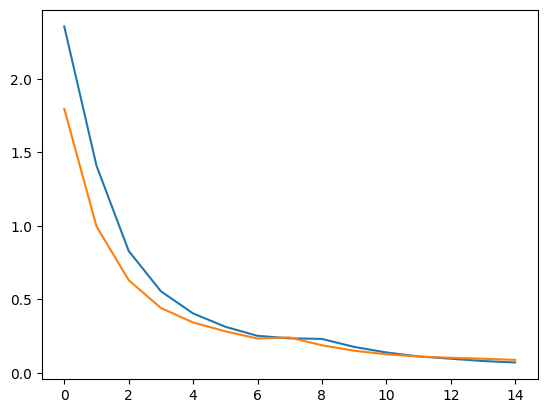

In [ ]:
# as you can see that both validation and training accuracy and loss matches Ive also checked precision and recall they are also toe to toe with
# each other which explains there is no overfitting involved in this scenario
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

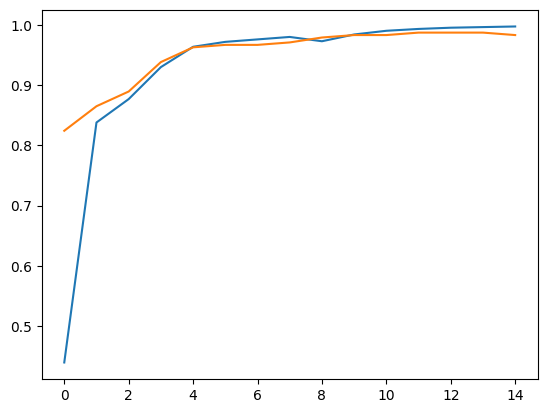

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
# streamlining the model to any inputs
from keras.preprocessing.text import Tokenizer

def predict(text):
    # cleaning the text
    cleaned_text = clean(text)

    # tokenize the data
    text_token = tokenizer.texts_to_sequences([cleaned_text])

    # pad it to the desired dimension
    padded_text = pad_sequences(text_token, padding='post',maxlen=57)

    # reshaping the padded output
    final_text = padded_text

    # Predict on the input data
    predictions = model.predict(final_text)

    # Finding the maximum prediction amongst the classes
    predicted_class_index = np.argmax(predictions)

    # all the class list
    class_labels = encoder.classes_.tolist()

    # extracting the label from the list
    predicted_class_label = class_labels[predicted_class_index]

    return {text :predicted_class_label}

In [ ]:
text = "Unloaded PRSJU"
predict(text)

1/1 [==============================] - 0s 38ms/step


{'Unloaded PRSJU': 'Unloaded on Vessel'}

In [ ]:
# pickling the import functions and model to use as an api in pycharm
import pickle

with open("model.pkl",'wb') as f:
  pickle.dump(model,f)

In [ ]:
with open("tokenizer.pkl",'wb') as t:
  pickle.dump(tokenizer,t)